In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import re
import warnings
import os
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Download and Load GloVe Embeddings

We'll use pre-trained GloVe vectors. For this demo, we'll simulate loading GloVe vectors.
In practice, download from: https://nlp.stanford.edu/projects/glove/

Common options:
- glove.6B.50d.txt (50 dimensions)
- glove.6B.100d.txt (100 dimensions)
- glove.6B.200d.txt (200 dimensions)
- glove.6B.300d.txt (300 dimensions)

In [2]:
def load_glove_embeddings(file_path, max_words=None):
    """
    Load pre-trained GloVe embeddings from file.
    
    Parameters:
    -----------
    file_path : str
        Path to GloVe embeddings file
    max_words : int, optional
        Maximum number of words to load
    
    Returns:
    --------
    dict : word -> vector mapping
    """
    embeddings_index = {}
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                if max_words and idx >= max_words:
                    break
                
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = vector
        
        print(f"Loaded {len(embeddings_index)} word vectors")
        return embeddings_index
    
    except FileNotFoundError:
        print(f"GloVe file not found at {file_path}")
        print("Please download GloVe embeddings from: https://nlp.stanford.edu/projects/glove/")
        print("\nFor demo purposes, we'll create synthetic embeddings...")
        return None

# Attempt to load GloVe embeddings
glove_path = 'glove.6B.100d.txt'  # Adjust path as needed
glove_embeddings = load_glove_embeddings(glove_path)

GloVe file not found at glove.6B.100d.txt
Please download GloVe embeddings from: https://nlp.stanford.edu/projects/glove/

For demo purposes, we'll create synthetic embeddings...


In [3]:
# If GloVe file not found, create a simple demo embedding system
if glove_embeddings is None:
    print("Creating demo embeddings based on Word2Vec for demonstration...")
    from gensim.models import Word2Vec
    from gensim.utils import simple_preprocess
    
    # We'll use Word2Vec as a proxy for GloVe in this demo
    # In production, use actual GloVe embeddings
    USE_DEMO_MODE = True
    EMBEDDING_DIM = 100
else:
    USE_DEMO_MODE = False
    EMBEDDING_DIM = len(next(iter(glove_embeddings.values())))
    print(f"Using GloVe embeddings with dimension: {EMBEDDING_DIM}")

Creating demo embeddings based on Word2Vec for demonstration...


In [4]:
# Load the data
df = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (104, 5)

First few rows:


,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources prof...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN
6,7,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN
8,9,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
9,10,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,NaN


## GloVe Ranking System

In [5]:
class GloVeRankingSystem:
    """
    A ranking system using GloVe embeddings for semantic matching.
    """
    
    def __init__(self, keywords, glove_embeddings=None, use_connections=True):
        """
        Initialize the GloVe ranking system.
        
        Parameters:
        -----------
        keywords : str or list
            Target role keywords to match against
        glove_embeddings : dict
            Pre-trained GloVe embeddings (word -> vector)
        use_connections : bool
            Whether to factor in number of connections
        """
        self.keywords = keywords if isinstance(keywords, str) else ' '.join(keywords)
        self.use_connections = use_connections
        self.glove_embeddings = glove_embeddings
        self.embedding_dim = EMBEDDING_DIM
        self.starred_candidates = []
        self.ranking_history = []
        
        # If no GloVe embeddings, train a simple model for demo
        if self.glove_embeddings is None and USE_DEMO_MODE:
            self.demo_model = None
        
    def preprocess_text(self, text):
        """Clean and preprocess text data."""
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        return text
    
    def tokenize(self, text):
        """Tokenize text into words."""
        return self.preprocess_text(text).split()
    
    def normalize_connections(self, connections_series):
        """Normalize connection counts to 0-1 scale."""
        def parse_connection(conn):
            if pd.isna(conn):
                return 0
            conn_str = str(conn).strip()
            if '500+' in conn_str:
                return 500
            try:
                return int(conn_str)
            except:
                return 0
        
        connections_numeric = connections_series.apply(parse_connection)
        max_conn = connections_numeric.max()
        if max_conn > 0:
            return connections_numeric / max_conn
        return connections_numeric
    
    def get_word_vector(self, word):
        """Get vector for a single word."""
        if self.glove_embeddings:
            return self.glove_embeddings.get(word, np.zeros(self.embedding_dim))
        else:
            # Demo mode: use Word2Vec
            if word in self.demo_model.wv:
                return self.demo_model.wv[word]
            return np.zeros(self.embedding_dim)
    
    def get_document_vector(self, tokens):
        """
        Get document vector by averaging word vectors.
        """
        vectors = []
        for token in tokens:
            vec = self.get_word_vector(token)
            if np.any(vec):  # Not a zero vector
                vectors.append(vec)
        
        if len(vectors) == 0:
            return np.zeros(self.embedding_dim)
        
        return np.mean(vectors, axis=0)
    
    def train_demo_model(self, df):
        """Train a demo model if GloVe embeddings not available."""
        if USE_DEMO_MODE and self.demo_model is None:
            from gensim.models import Word2Vec
            from gensim.utils import simple_preprocess
            
            tokenized_titles = [simple_preprocess(self.preprocess_text(title)) 
                              for title in df['job_title']]
            tokenized_keywords = [simple_preprocess(self.preprocess_text(self.keywords))]
            all_documents = tokenized_keywords + tokenized_titles
            
            self.demo_model = Word2Vec(
                sentences=all_documents,
                vector_size=self.embedding_dim,
                window=5,
                min_count=1,
                workers=4,
                epochs=100,
                sg=1
            )
            print("Demo model trained (simulating GloVe with Word2Vec)")
    
    def calculate_initial_fit(self, df):
        """Calculate initial fitness scores using GloVe embeddings."""
        # Train demo model if needed
        if USE_DEMO_MODE:
            self.train_demo_model(df)
        
        # Get keyword vector
        keyword_tokens = self.tokenize(self.keywords)
        keyword_vector = self.get_document_vector(keyword_tokens).reshape(1, -1)
        
        # Get vectors for all job titles
        job_vectors = []
        for title in df['job_title']:
            tokens = self.tokenize(title)
            vector = self.get_document_vector(tokens)
            job_vectors.append(vector)
        
        job_vectors = np.array(job_vectors)
        
        # Calculate cosine similarity
        similarities = cosine_similarity(keyword_vector, job_vectors).flatten()
        
        # Factor in connections if enabled
        if self.use_connections and 'connection' in df.columns:
            connection_scores = self.normalize_connections(df['connection'])
            final_scores = 0.8 * similarities + 0.2 * connection_scores
        else:
            final_scores = similarities
        
        return final_scores
    
    def calculate_fit_with_feedback(self, df, starred_indices):
        """Recalculate fitness incorporating starred candidates."""
        # Get keyword vector
        keyword_tokens = self.tokenize(self.keywords)
        keyword_vector = self.get_document_vector(keyword_tokens).reshape(1, -1)
        
        # Get vectors for all job titles
        job_vectors = []
        for title in df['job_title']:
            tokens = self.tokenize(title)
            vector = self.get_document_vector(tokens)
            job_vectors.append(vector)
        
        job_vectors = np.array(job_vectors)
        
        # Base similarity to keywords
        keyword_similarities = cosine_similarity(keyword_vector, job_vectors).flatten()
        
        if len(starred_indices) > 0:
            # Calculate similarity to starred candidates
            starred_vectors = job_vectors[starred_indices]
            starred_similarities = cosine_similarity(job_vectors, starred_vectors)
            max_starred_sim = starred_similarities.max(axis=1)
            
            # Combine scores
            weight_starred = min(0.6, 0.3 + (len(starred_indices) * 0.05))
            weight_keyword = 1 - weight_starred
            
            combined_scores = (weight_keyword * keyword_similarities + 
                             weight_starred * max_starred_sim)
        else:
            combined_scores = keyword_similarities
        
        # Factor in connections
        if self.use_connections and 'connection' in df.columns:
            connection_scores = self.normalize_connections(df['connection'])
            final_scores = 0.85 * combined_scores + 0.15 * connection_scores
        else:
            final_scores = combined_scores
        
        return final_scores
    
    def rank_candidates(self, df, starred_indices=None):
        """Rank candidates and return sorted dataframe."""
        df_copy = df.copy()
        
        if starred_indices is None or len(starred_indices) == 0:
            fit_scores = self.calculate_initial_fit(df_copy)
        else:
            fit_scores = self.calculate_fit_with_feedback(df_copy, starred_indices)
        
        df_copy['fit_glove'] = fit_scores
        df_copy = df_copy.sort_values('fit_glove', ascending=False).reset_index(drop=True)
        df_copy['rank'] = range(1, len(df_copy) + 1)
        
        self.ranking_history.append(df_copy[['id', 'rank', 'fit_glove']].copy())
        
        return df_copy
    
    def star_candidate(self, df, candidate_rank):
        """Star a candidate and re-rank."""
        candidate_idx = df.index[df['rank'] == candidate_rank].tolist()[0]
        
        if candidate_idx not in self.starred_candidates:
            self.starred_candidates.append(candidate_idx)
            print(f"✭ Starred: {df.loc[candidate_idx, 'job_title']}")
        
        return self.rank_candidates(df, self.starred_candidates)

print("GloVeRankingSystem class defined successfully!")

GloVeRankingSystem class defined successfully!


In [6]:
# Initialize GloVe ranking system
keywords = "aspiring human resources seeking human resources"
glove_system = GloVeRankingSystem(keywords, glove_embeddings=glove_embeddings, use_connections=True)

print(f"GloVe system initialized with keywords: '{keywords}'")
if USE_DEMO_MODE:
    print("Note: Running in DEMO MODE (simulating GloVe with Word2Vec)")
    print("For production use, download actual GloVe embeddings")

GloVe system initialized with keywords: 'aspiring human resources seeking human resources'
Note: Running in DEMO MODE (simulating GloVe with Word2Vec)
For production use, download actual GloVe embeddings


In [7]:
# Rank candidates using GloVe
ranked_glove = glove_system.rank_candidates(df)

print("GloVe Ranking Complete!")
print(f"\nTop 15 Candidates (GloVe):")
print("="*100)
ranked_glove[['rank', 'job_title', 'location', 'connection', 'fit_glove']].head(15)

Demo model trained (simulating GloVe with Word2Vec)
GloVe Ranking Complete!

Top 15 Candidates (GloVe):


,rank,job_title,location,connection,fit_glove
0,1,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.996310
1,2,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.996310
2,3,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.996310
3,4,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.996310
4,5,"Human Resources, Staffing and Recruiting Professional","Jackson, Mississippi Area",500+,0.990366
5,6,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,0.988905
6,7,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,0.988905
7,8,Human Resources Generalist at Schwan's,Amerika Birleşik Devletleri,500+,0.972111
8,9,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,0.970473
9,10,"Human Resources Generalist at ScottMadden, Inc.","Raleigh-Durham, North Carolina Area",500+,0.958965


## Compare with TF-IDF Baseline

In [8]:
# Create TF-IDF baseline for comparison
from sklearn.feature_extraction.text import TfidfVectorizer

class TFIDFRankingSystem:
    """Baseline TF-IDF system for comparison."""
    
    def __init__(self, keywords, use_connections=True):
        self.keywords = keywords if isinstance(keywords, str) else ' '.join(keywords)
        self.use_connections = use_connections
        self.vectorizer = TfidfVectorizer(
            stop_words='english',
            ngram_range=(1, 3),
            min_df=1,
            lowercase=True
        )
    
    def preprocess_text(self, text):
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        return text
    
    def normalize_connections(self, connections_series):
        def parse_connection(conn):
            if pd.isna(conn):
                return 0
            conn_str = str(conn).strip()
            if '500+' in conn_str:
                return 500
            try:
                return int(conn_str)
            except:
                return 0
        
        connections_numeric = connections_series.apply(parse_connection)
        max_conn = connections_numeric.max()
        if max_conn > 0:
            return connections_numeric / max_conn
        return connections_numeric
    
    def calculate_initial_fit(self, df):
        df['processed_title'] = df['job_title'].apply(self.preprocess_text)
        all_texts = [self.keywords] + df['processed_title'].tolist()
        tfidf_matrix = self.vectorizer.fit_transform(all_texts)
        
        keyword_vector = tfidf_matrix[0:1]
        candidate_vectors = tfidf_matrix[1:]
        
        similarities = cosine_similarity(keyword_vector, candidate_vectors).flatten()
        
        if self.use_connections and 'connection' in df.columns:
            connection_scores = self.normalize_connections(df['connection'])
            final_scores = 0.8 * similarities + 0.2 * connection_scores
        else:
            final_scores = similarities
        
        return final_scores
    
    def rank_candidates(self, df):
        df_copy = df.copy()
        fit_scores = self.calculate_initial_fit(df_copy)
        df_copy['fit_tfidf'] = fit_scores
        df_copy = df_copy.sort_values('fit_tfidf', ascending=False).reset_index(drop=True)
        return df_copy

# Create TF-IDF baseline
tfidf_system = TFIDFRankingSystem(keywords, use_connections=True)
ranked_tfidf = tfidf_system.rank_candidates(df)

print("TF-IDF baseline created for comparison")

TF-IDF baseline created for comparison


In [9]:
# Merge results for comparison
comparison_df = ranked_glove[['id', 'job_title', 'location', 'connection', 'rank', 'fit_glove']].copy()
comparison_df = comparison_df.rename(columns={'rank': 'rank_glove'})

tfidf_ranks = ranked_tfidf[['id', 'fit_tfidf']].copy()
tfidf_ranks['rank_tfidf'] = range(1, len(tfidf_ranks) + 1)

comparison_df = comparison_df.merge(tfidf_ranks, on='id', how='left')
comparison_df['rank_difference'] = comparison_df['rank_tfidf'] - comparison_df['rank_glove']

print("Top 20 Candidates - GloVe vs TF-IDF Comparison:")
print("="*120)
comparison_df[['rank_glove', 'rank_tfidf', 'rank_difference', 'job_title', 
               'fit_glove', 'fit_tfidf']].head(20)

Top 20 Candidates - GloVe vs TF-IDF Comparison:


,rank_glove,rank_tfidf,rank_difference,job_title,fit_glove,fit_tfidf
0,1,3,2,Seeking Human Resources HRIS and Generalist Positions,0.996310,0.416951
1,2,4,2,Seeking Human Resources HRIS and Generalist Positions,0.996310,0.416951
2,3,5,2,Seeking Human Resources HRIS and Generalist Positions,0.996310,0.416951
3,4,6,2,Seeking Human Resources HRIS and Generalist Positions,0.996310,0.416951
4,5,27,22,"Human Resources, Staffing and Recruiting Professional",0.990366,0.264212
5,6,8,2,Aspiring Human Resources Management student seeking an internship,0.988905,0.352899
6,7,7,0,Aspiring Human Resources Management student seeking an internship,0.988905,0.352899
7,8,21,13,Human Resources Generalist at Schwan's,0.972111,0.287764
8,9,19,10,Human Resources Generalist at Loparex,0.970473,0.287764
9,10,20,10,"Human Resources Generalist at ScottMadden, Inc.",0.958965,0.287764


## Visualization: GloVe vs TF-IDF

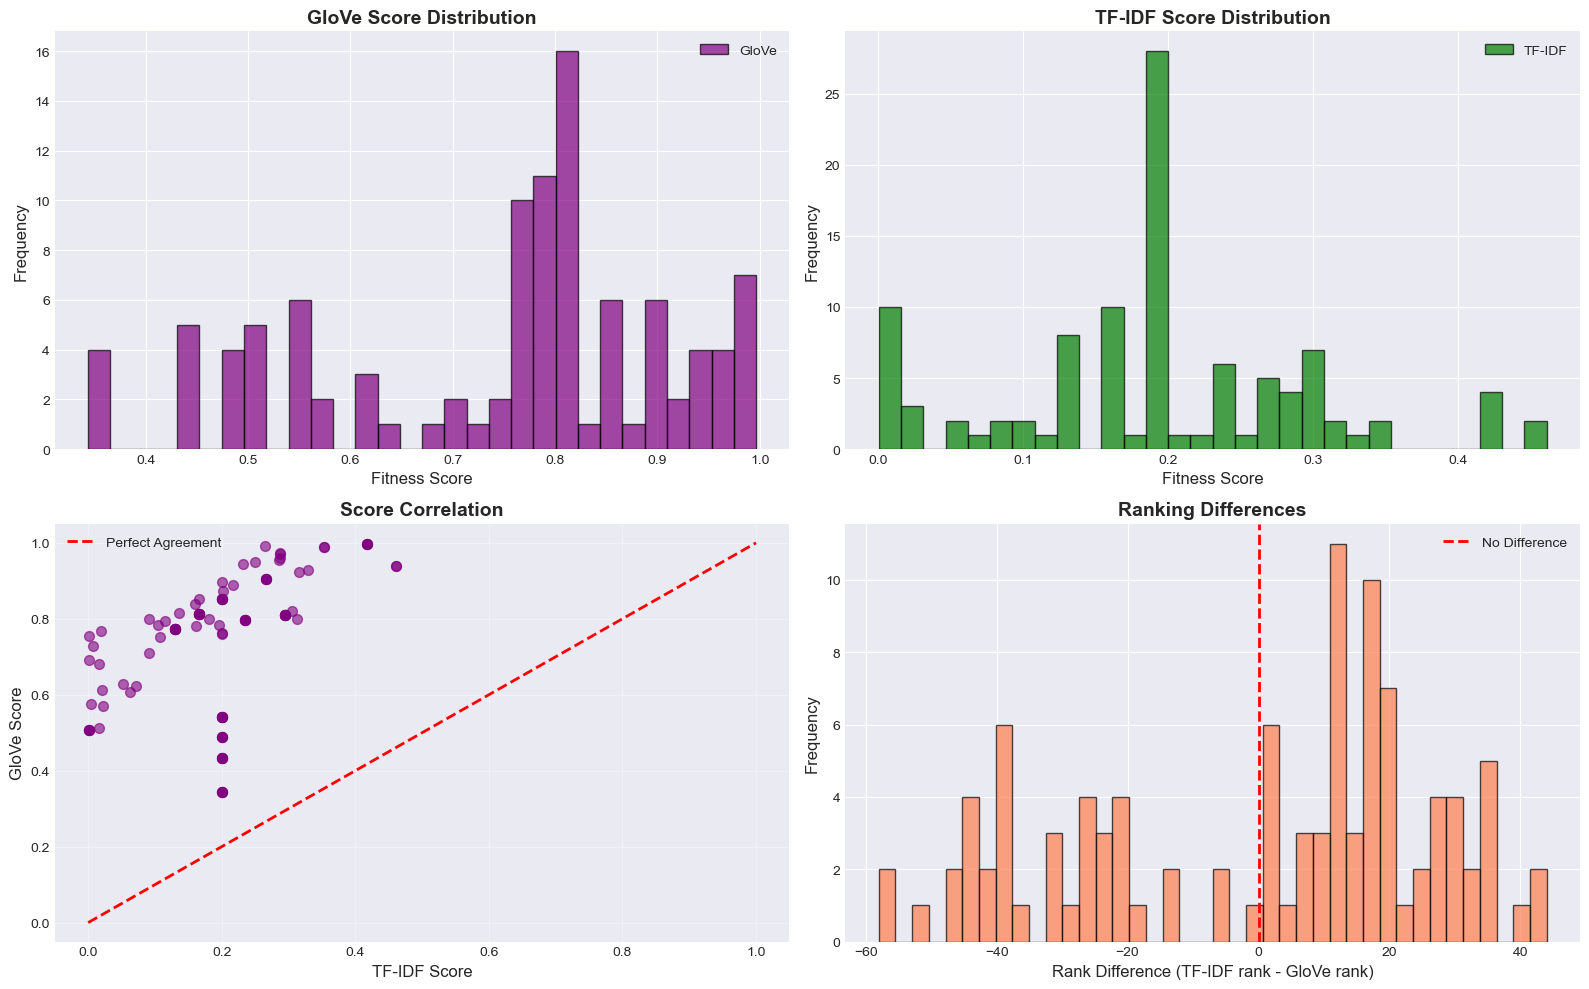


Correlation between GloVe and TF-IDF scores: 0.5058


In [10]:
# Score distribution comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histograms
axes[0, 0].hist(comparison_df['fit_glove'], bins=30, alpha=0.7, label='GloVe', color='purple', edgecolor='black')
axes[0, 0].set_xlabel('Fitness Score', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('GloVe Score Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()

axes[0, 1].hist(comparison_df['fit_tfidf'], bins=30, alpha=0.7, label='TF-IDF', color='green', edgecolor='black')
axes[0, 1].set_xlabel('Fitness Score', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('TF-IDF Score Distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend()

# Scatter plot: GloVe vs TF-IDF scores
axes[1, 0].scatter(comparison_df['fit_tfidf'], comparison_df['fit_glove'], alpha=0.6, s=50, color='purple')
axes[1, 0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Agreement')
axes[1, 0].set_xlabel('TF-IDF Score', fontsize=12)
axes[1, 0].set_ylabel('GloVe Score', fontsize=12)
axes[1, 0].set_title('Score Correlation', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Rank difference distribution
axes[1, 1].hist(comparison_df['rank_difference'], bins=40, alpha=0.7, color='coral', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Difference')
axes[1, 1].set_xlabel('Rank Difference (TF-IDF rank - GloVe rank)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Ranking Differences', fontsize=14, fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = comparison_df['fit_glove'].corr(comparison_df['fit_tfidf'])
print(f"\nCorrelation between GloVe and TF-IDF scores: {correlation:.4f}")

In [11]:
# Statistical comparison
print("Statistical Comparison:")
print("="*80)
print(f"\nGloVe Scores:")
print(f"  Mean: {comparison_df['fit_glove'].mean():.4f}")
print(f"  Std:  {comparison_df['fit_glove'].std():.4f}")
print(f"  Min:  {comparison_df['fit_glove'].min():.4f}")
print(f"  Max:  {comparison_df['fit_glove'].max():.4f}")

print(f"\nTF-IDF Scores:")
print(f"  Mean: {comparison_df['fit_tfidf'].mean():.4f}")
print(f"  Std:  {comparison_df['fit_tfidf'].std():.4f}")
print(f"  Min:  {comparison_df['fit_tfidf'].min():.4f}")
print(f"  Max:  {comparison_df['fit_tfidf'].max():.4f}")

print(f"\nRank Differences:")
print(f"  Mean Absolute Difference: {comparison_df['rank_difference'].abs().mean():.2f}")
print(f"  Max Rank Change: {comparison_df['rank_difference'].abs().max():.0f}")
print(f"  Candidates with >10 rank difference: {(comparison_df['rank_difference'].abs() > 10).sum()}")

Statistical Comparison:

GloVe Scores:
  Mean: 0.7433
  Std:  0.1774
  Min:  0.3440
  Max:  0.9963

TF-IDF Scores:
  Mean: 0.1938
  Std:  0.1066
  Min:  0.0008
  Max:  0.4610

Rank Differences:
  Mean Absolute Difference: 23.50
  Max Rank Change: 58
  Candidates with >10 rank difference: 88


In [12]:
# Show candidates that differ the most in ranking
print("\nCandidates Ranked Much Higher by GloVe (vs TF-IDF):")
print("="*120)
top_glove = comparison_df.nsmallest(10, 'rank_difference')
print(top_glove[['rank_glove', 'rank_tfidf', 'rank_difference', 'job_title', 
                 'fit_glove', 'fit_tfidf']].to_string(index=False))

print("\n\nCandidates Ranked Much Higher by TF-IDF (vs GloVe):")
print("="*120)
top_tfidf = comparison_df.nlargest(10, 'rank_difference')
print(top_tfidf[['rank_glove', 'rank_tfidf', 'rank_difference', 'job_title', 
                 'fit_glove', 'fit_tfidf']].to_string(index=False))


Candidates Ranked Much Higher by GloVe (vs TF-IDF):
 rank_glove  rank_tfidf  rank_difference                                                                                                   job_title  fit_glove  fit_tfidf
         95          37              -58                                                             Advisory Board Member at Celal Bayar University   0.489138        0.2
         96          39              -57                                                   Native English Teacher at EPIK (English Program in Korea)   0.433631        0.2
        102          50              -52 SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR   0.343953        0.2
         93          46              -47                                                             Advisory Board Member at Celal Bayar University   0.489138        0.2
         98          52              -46                                                   N

## Key Insights

### GloVe Strengths:
1. **Pre-trained Knowledge**: Leverages word relationships learned from massive corpora
2. **Better Generalization**: Can handle words not in training data (if in pre-trained vocab)
3. **Global Context**: Captures co-occurrence statistics across entire corpus

### GloVe Limitations:
1. **Fixed Vocabulary**: Limited to words in pre-trained embeddings
2. **Context Agnostic**: Same vector for a word regardless of context
3. **Averaging Issues**: Document representation by averaging can lose information

### Comparison with TF-IDF:
- **Pre-training Advantage**: GloVe benefits from external knowledge
- **Vocabulary Coverage**: GloVe covers more words if using large pre-trained model
- **Semantic Richness**: Better at capturing meaning than frequency-based TF-IDF

In [13]:
# Save comparison results
comparison_df.to_csv('glove_vs_tfidf_comparison.csv', index=False)
print("Comparison results saved to 'glove_vs_tfidf_comparison.csv'")

Comparison results saved to 'glove_vs_tfidf_comparison.csv'
